# Psychoinformatics - Week 13 (Exercises)
賴誌凱  r13h41015@ntu.edu.tw

In [3]:
#%pip install -q --no-cache-dir lz4 ultralytics mtcnn opencv-python matplotlib
#%pip install -q --no-cache-dir tensorflow pillow

## 1 進一步研究CNN (3 points)

### 1.1 為何ResNet50會判斷小女孩照片為ping-pong_bal, bubble, or Band_Aid? (3 points)

In [ ]:
import numpy as np
import urllib.request
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions

model = ResNet50(weights='imagenet')

urllib.request.urlretrieve('http://mil.psy.ntu.edu.tw/~tren/girl.jpg','girl.jpg')
img = image.load_img('girl.jpg', target_size=(224, 224)) # Or use cv2.resize to resize images
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

preds = model.predict(x)
# decode the results into a list of tuples (class, description, probability)
# (one such list for each sample in the batch)
print('Predicted:', decode_predictions(preds, top=3)[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Predicted: [('n03942813', 'ping-pong_ball', np.float32(0.17008671)), ('n09229709', 'bubble', np.float32(0.10647246)), ('n02786058', 'Band_Aid', np.float32(0.10364477))]


Please write your discussion here

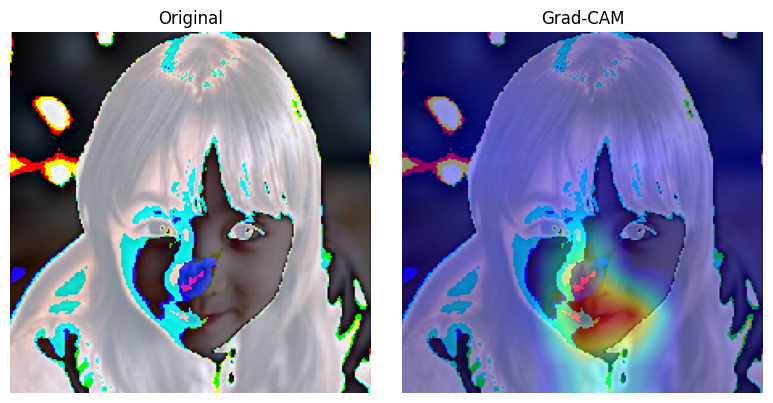

In [ ]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.preprocessing import image

model = ResNet50(weights='imagenet')
img_path = 'girl.jpg'
img = image.load_img(img_path, target_size=(224, 224))
img_array = image.img_to_array(img)
input_tensor = np.expand_dims(img_array, axis=0)
input_tensor = preprocess_input(input_tensor)

last_conv_layer_name = "conv5_block3_out"
last_conv_layer = model.get_layer(last_conv_layer_name)

heatmap_model = tf.keras.models.Model(
    [model.inputs], [last_conv_layer.output, model.output]
)

with tf.GradientTape() as tape:
    conv_outputs, predictions = heatmap_model(input_tensor)
    class_idx = tf.argmax(predictions[0])
    loss = predictions[:, class_idx]

grads = tape.gradient(loss, conv_outputs)          # d(loss)/d(conv_outputs)
pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

conv_outputs = conv_outputs[0]  # shape: (7, 7, channels)
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)

heatmap = np.maximum(heatmap, 0)
max_val = np.max(heatmap) + 1e-8
heatmap /= max_val

heatmap = cv2.resize(heatmap, (img_array.shape[1], img_array.shape[0]))
heatmap = np.uint8(255 * heatmap)

heatmap_color = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

orig = cv2.cvtColor(img_array.astype('uint8'), cv2.COLOR_RGB2BGR)
superimposed_img = cv2.addWeighted(orig, 0.6, heatmap_color, 0.4, 0)

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.title("Original")
plt.axis('off')
plt.imshow(cv2.cvtColor(orig, cv2.COLOR_BGR2RGB))

plt.subplot(1,2,2)
plt.title("Grad-CAM")
plt.axis('off')
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.tight_layout()
plt.show()


**文字解釋部分**

在這個例子中，ResNet50 並不是在理解「這是一個小女孩」，而是在 ImageNet 定義的 1000 個類別中，強迫為整張影像選出一個最相似的標籤。由於 ImageNet 並沒有 girl、child、person 這種語意類別，模型只能從「乒乓球、泡泡、OK 繃」這類物體中挑出與畫面中特徵最接近的幾種作為輸出，因此整個判斷一開始就受到類別集合的限制。

從上面產生的 Grad-CAM 來看，模型在做預測時，幾乎將注意力集中在鼻子與上嘴唇一帶，也就是那片綠色葉子所在的位置，而不是整張臉或頭髮。熱度圖顯示紅色和黃色區域集中在這個小區塊，背景與頭髮大多呈現冷色調，代表在模型眼中，真正被當成「待分類的主體」的是一個貼在皮膚上的小東西，而非一個人臉。這說明模型的任務在實際運算中變成「辨認鼻子上的那個物體」，而不是「辨認照片中的人物」。

在這樣的聚焦之下，鼻子上的葉子與鼻梁形成了一個小而突出的區域，具有接近圓形或橢圓形的輪廓、平滑的表面，以及與周邊膚色背景之間明顯的邊界。經過 224×224 縮放與多層卷積和池化後，顏色與細節被壓縮為較抽象的紋理表示，模型接收到的是「一個小巧、光滑、邊界清楚、從背景突出的物體」，這種特徵組合在 ImageNet 中與 ping-pong_ball 的典型特徵相當接近，因此乒乓球被排在第一名。模型無法「看見」綠色葉子，而是在高維特徵空間中把它投射到最像的小球類物體上。

同一張圖中，背景的散景以及臉部與葉子周圍的高光，組合起來呈現出多個模糊的亮點與圓形光斑，這種視覺效果和許多泡泡的拍攝影像存在相似之處。對卷積網路來說，這些區域會被視為「半透明或高亮邊緣的圓形斑點」，和 ImageNet 中 bubble 類別的紋理特徵具有一定的重疊。因此模型在綜合考量全圖特徵後，也傾向將這張影像與泡泡聯想在一起，於是 bubble 成為第二高的預測結果。

至於 Band_Aid，ImageNet 中這個類別大多出現在貼在皮膚表面的細長貼片情境，典型畫面是一塊顏色與周圍膚色對比不大的小物體，緊貼在臉、手指或手臂上。鼻子上的葉子同樣是一個貼在皮膚上的小物體，邊界清晰，附近是大面積的膚色區域。從特徵表示的角度來看，這種「小貼片貼在皮膚上」的結構與 Band_Aid 的訓練樣本十分相似，於是模型也為這個類別給出相對較高的分數，將它排為第三名。

綜合來說，ResNet50 在這張 girl.jpg 上的判斷並不是對「小女孩」的語意誤解，而是受限於 ImageNet 類別集合與模型的視覺特徵表示方式，將鼻子上的葉子連同周邊膚色與光影看成一個待分類的小物體，並依照其形狀、紋理及背景對比，分別對應到乒乓球、泡泡與 OK 繃這幾個在訓練資料中具有相似視覺模式的類別，因此形成 ping-pong_ball、bubble、Band_Aid 這樣的前三高預測結果。

### 1.2 請展示有別人pre-trained好的Keras model可以成功辨認girl.jpg為人臉 (3 points)

In [ ]:
# Please write your codes here

一、使用MTCNN（Multi-task Cascaded CNN）人臉偵測器

偵測到的人臉數量: 1


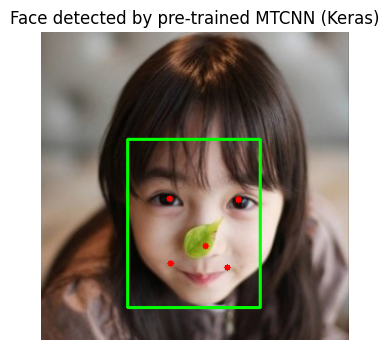

In [25]:
from mtcnn import MTCNN
import cv2
import matplotlib.pyplot as plt

img_path = 'girl.jpg'
img_bgr = cv2.imread(img_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

detector = MTCNN()
results = detector.detect_faces(img_rgb)

print("偵測到的人臉數量:", len(results))

for r in results:
    x, y, w, h = r['box']
    cv2.rectangle(img_rgb, (x, y), (x + w, y + h), (0, 255, 0), 2)

    keypoints = r['keypoints']
    for key, point in keypoints.items():
        cv2.circle(img_rgb, point, 3, (255, 0, 0), -1)

plt.figure(figsize=(4,4))
plt.imshow(img_rgb)
plt.axis('off')
plt.title('Face detected by pre-trained MTCNN (Keras)')
plt.show()


二、使用 YOLOv8n-Face 預訓練人臉偵測模型(非Keras model)

偵測到的人臉數量: 1


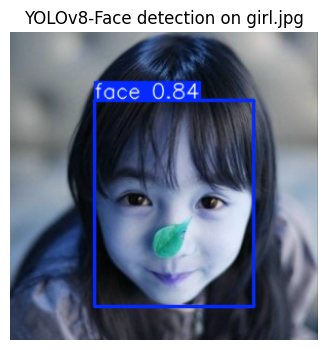

In [24]:
import urllib.request
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO

urllib.request.urlretrieve(
    'http://mil.psy.ntu.edu.tw/~tren/girl.jpg',
    'girl.jpg'
)

!wget -q 'https://github.com/lindevs/yolov8-face/releases/latest/download/yolov8n-face-lindevs.pt' -O yolov8n-face.pt

img_bgr = cv2.imread('girl.jpg')
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

model = YOLO('yolov8n-face.pt')

results = model.predict(source=img_rgb, conf=0.25, verbose=False)
r = results[0]

print("偵測到的人臉數量:", len(r.boxes))

annotated_bgr = r.plot()
annotated_rgb = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(4, 4))
plt.imshow(annotated_rgb)
plt.axis('off')
plt.title('YOLOv8-Face detection on girl.jpg')
plt.show()
